In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
model_folder = 'C:/Users\lukec\PycharmProjects\emissions-tracking-conda\emissions-tracking\models/'
datasets = ['petrochemicals/', 'CT_manufacturing/', 'unfccc/']

In [3]:
# Fetch model files

clf_files, dataset_type = [], []
for dataset in datasets:
    d_files = [file for file in os.listdir(model_folder+dataset) if 'clf' in file and '.npy' in file and 'split' not in file and '2306' in file]
    clf_files = clf_files+d_files
    dataset_type = dataset_type+[dataset[:-1]]*len(d_files)

clf_file_df = pd.DataFrame([clf_files, dataset_type, [i+'/'+j for (i,j) in zip(dataset_type,clf_files)]]).transpose()
clf_file_df.columns = ['Classifier', 'Dataset', 'Filepath']
clf_file_df['June_day'] = [i.split('2306')[1][:2] for i in clf_file_df['Classifier']]
clf_file_df['Class'] = [i.split('_')[1] for i in clf_file_df['Classifier']]
clf_file_df['Level'] = [i.split('_')[2] for i in clf_file_df['Classifier']]
clf_file_df = clf_file_df.sort_values(['June_day'])#.groupby(['Dataset', 'Level', 'Class']).last().reset_index
clf_file_df[clf_file_df['June_day'].astype(int) > 2]

,Classifier,Dataset,Filepath,June_day,Class,Level
249,clf_GCN-h64_l3_230603.npy,CT_manufacturing,CT_manufacturing/clf_GCN-h64_l3_230603.npy,03,GCN-h64,l3
49,clf_GCN-h64_l2_230603.npy,petrochemicals,petrochemicals/clf_GCN-h64_l2_230603.npy,03,GCN-h64,l2
177,clf_SAGE-h64_l1_230603.npy,petrochemicals,petrochemicals/clf_SAGE-h64_l1_230603.npy,03,SAGE-h64,l1
280,clf_linearSGDClassifier_l1_230603.npy,CT_manufacturing,CT_manufacturing/clf_linearSGDClassifier_l1_23...,03,linearSGDClassifier,l1
381,clf_SAGE-h64_l1_230603.npy,CT_manufacturing,CT_manufacturing/clf_SAGE-h64_l1_230603.npy,03,SAGE-h64,l1
...,...,...,...,...,...,...
7,clf_adaBoostClassifier_l3_230606.npy,petrochemicals,petrochemicals/clf_adaBoostClassifier_l3_23060...,06,adaBoostClassifier,l3
141,clf_naiveBayesClassifier_l3_230606.npy,petrochemicals,petrochemicals/clf_naiveBayesClassifier_l3_230...,06,naiveBayesClassifier,l3
386,clf_SAGE_l1_230610_0.01_64_20iter.npy,CT_manufacturing,CT_manufacturing/clf_SAGE_l1_230610_0.01_64_20...,10,SAGE,l1
251,clf_GIN_l1_230610_0.01_64_20iter.npy,CT_manufacturing,CT_manufacturing/clf_GIN_l1_230610_0.01_64_20i...,10,GIN,l1


In [4]:
# Performance for different classifiers and levels
all_scores = pd.DataFrame()
for i, model in enumerate(clf_file_df.iloc):
    scores = np.load(model_folder+model['Filepath'], allow_pickle=True).item()
    df = pd.DataFrame.from_dict(scores, orient='index').transpose()
    df['Name'] = model['Class']#.split('_')[1]
    df['Level'] = model['Level'][1:]#.replace('__','_').split('_')[2][1]
    df['Dataset'] = model['Dataset']
    df['Filepath'] = model['Filepath']
    all_scores = pd.concat((all_scores, df))

C:\Users\lukec\AppData\Roaming\Python\Python39\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [5]:
all_scores = all_scores.sort_values('average_acc').groupby(['Dataset', 'Level', 'Name']).last().reset_index()

In [6]:
all_scores

,Dataset,Level,Name,confusion,overall_acc,average_acc,kappa,IoU,Filepath
0,CT_manufacturing,1,DeepNet,"[[11830, 3867, 4847, 3768], [2276, 10433, 6458...",0.618270,0.623610,0.493091,0.447081,CT_manufacturing/clf_DeepNet_l1_230605_0.01_25...
1,CT_manufacturing,1,GCN,"[[7972, 5030, 5578, 2328], [2878, 9261, 7109, ...",0.478250,0.478250,0.304333,0.320401,CT_manufacturing/clf_GCN_l1_230610_0.01_64_20i...
2,CT_manufacturing,1,GCN-h64,"[[12472, 3706, 4608, 3569], [5040, 6955, 6461,...",0.524677,0.525463,0.366318,0.355578,CT_manufacturing/clf_GCN-h64_l1_230602.npy
3,CT_manufacturing,1,GIN,"[[4628, 5265, 8746, 2269], [3474, 6007, 8894, ...",0.332050,0.332050,0.109400,0.206774,CT_manufacturing/clf_GIN_l1_230610_0.01_64_20i...
4,CT_manufacturing,1,KNeighboursClassifier,"[[19561, 2442, 1420, 932], [2494, 15369, 2767,...",0.787971,0.787447,0.716821,0.653257,CT_manufacturing/clf_KNeighboursClassifier_l1_...
...,...,...,...,...,...,...,...,...,...
190,unfccc,3,linearmean,"[[5434, 3175, 6040, 2378], [479, 3537, 7993, 5...",0.424420,0.424420,0.232562,0.264385,unfccc/clf_linearmean_l3_230605.npy
191,unfccc,3,mlpClassifier,"[[9977, 4482, 1568, 631], [4239, 7207, 3929, 1...",0.475825,0.477424,0.301258,0.319001,unfccc/clf_mlpClassifier_l3_230605.npy
192,unfccc,3,naiveBayesClassifier,"[[12214, 352, 1846, 2098], [9084, 909, 2657, 4...",0.367055,0.368739,0.157710,0.196799,unfccc/clf_naiveBayesClassifier_l3_230601.npy
193,unfccc,3,poly3,"[[5434, 3175, 6040, 2378], [479, 3537, 7993, 5...",0.424420,0.424420,0.232562,0.264385,unfccc/clf_poly3_l3_230605.npy


In [7]:
def manual_sorting(df:pd.DataFrame, column:str, sort_dict:dict, order_col:str = 'Order'):
    df_mapping = pd.DataFrame(sort_dict)
    sort_mapping = df_mapping.reset_index().set_index(column)
    df[order_col] = df[column].map(sort_mapping['index'])
    return df

In [8]:
groups_dict = {'poly3':'Interpolation', 'linearmean':'Interpolation',
          'linearLogisticRegression': 'Shallow', 'linearSGDClassifier':'Shallow', 'linearSVC':'Shallow','KNeighboursClassifier':'Shallow', 'decisionTreeClassifier':'Shallow', 'linearPassiveAggressiveClassifier':'Shallow', 'naiveBayesClassifier':'Shallow', 'linearPerceptron':'Shallow',
          'adaBoostClassifier':'Ensemble', 'randomForestClassifier': 'Ensemble',
          'mlpClassifier': 'Deep', 'DeepNet':'Deep', 'LSTM':'Deep','ResNet':'Deep',
           'GCN-h64':'Graph', 'SAGE-h64':'Graph'}
all_scores['Group'] = all_scores['Name'].replace(groups_dict)

names_dict = {'linearmean':'Mean', 'poly3':'Polynomial',
              'linearLogisticRegression': 'Logistic Regression', 'linearSGDClassifier':'SGD', 'linearSVC':'SVC', 'linearPassiveAggressiveClassifier':'Passive Aggressive', 'naiveBayesClassifier':'Naive Bayes', 'decisionTreeClassifier':'Decision Tree', 'KNeighboursClassifier':'k Nearest Neighbours', 'linearPerceptron':'Perceptron',
              'adaBoostClassifier':'AdaBoost', 'randomForestClassifier-n50': 'Random Forest',
              'mlpClassifier': 'Multilayer Perceptron', 'DeepNet':'DeepNet', 'LSTM':'LSTM', 'ResNet':'ResNet',
              'GCN-h64':'GCN', 'SAGE-h64':'SAGE'}
all_scores['Name'] = all_scores['Name'].replace(names_dict)

all_scores = manual_sorting(all_scores, 'Group', {'Group': ['Interpolation', 'Shallow', 'Ensemble', 'Deep', 'Graph']})
all_scores = manual_sorting(all_scores, 'Name', {'Name': list(names_dict.values())}, 'Order 2')

def calculate_f1_score(conf):
    confusion = np.array(conf)
    tp = np.diag(confusion)
    fp = np.sum(confusion, axis=0) - tp
    fn = np.sum(confusion, axis=1) - tp

    # Calculate precision, recall, and F1 score for each class
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Calculate the average F1 score
    return np.mean(f1_score)

all_scores['f1_score'] = all_scores['confusion'].apply(calculate_f1_score)

## Classifier heatmap plot

In [9]:
all_scores = all_scores.sort_values('Order 2')
all_scores['Dataset'] = all_scores['Dataset'].replace({'CT_manufacturing':'Climate\nTRACE', 'unfccc':'UNFCCC', 'petrochemicals':'Petro-\n-chems'})

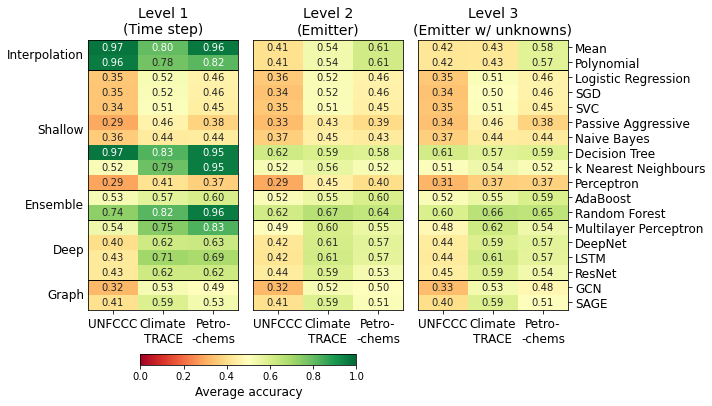

In [16]:
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
fig, axs = plt.subplots(1,3, figsize=[10,5], facecolor='white')

fontsize=12
property = 'average_acc'
vals = [2, 10, 12, 16]
tick_marks = [1, 6, 11, 14, 17]

norm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
for (ax, level, level_name) in zip(axs, ['1', '2', '3'], ['1\n(Time step)', '2\n(Emitter)', '3\n(Emitter w/ unknowns)']):
    heatmap = all_scores[['Order 2', 'Level', 'Group', 'Dataset', 'Name', property]].groupby(['Order 2', 'Level', 'Dataset', 'Name']).first().reset_index()
    heatmap = heatmap[heatmap['Level']==level]
    plot_array = heatmap.pivot(index='Order 2', columns='Dataset', values=property)
    plot_array = plot_array[['UNFCCC', 'Climate\nTRACE', 'Petro-\n-chems']]
    plot_array.index = pd.Series(plot_array.index.astype(str)).replace(dict(zip(heatmap['Order 2'].astype(str), heatmap['Name'])))

    heatmap_plot = sns.heatmap(plot_array, annot=True, fmt=".2f", cmap='RdYlGn', ax=ax, norm=norm, cbar=False)# if ax!=axs[2] else True)
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=0, fontsize=fontsize)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    for val in vals:
        ax.axhline(val, color='k', linewidth=1)

    opax = ax.twinx()
    if ax == axs[2]:
        opax.set_yticks(np.flip(ax.get_yticks()))
        opax.set_ylim([0, max(ax.get_yticks())+0.5])
        opax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
    else: opax.set_yticks([])

    if ax != axs[0]:
        ax.set_yticks([])
    else:
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(list(pd.Series(groups_dict.values()).drop_duplicates()), rotation=0, fontsize=fontsize)
        ax.yaxis.set_tick_params(length=0)
    ax.set_title('Level '+level_name, fontsize=fontsize+2)

fig.tight_layout()

# Add the colorbar in a separate axis
cbar_ax = heatmap_plot.figure.add_axes([0.2,-0.025, 0.3, 0.03])  # [left, bottom, width, height]
colorbar = heatmap_plot.figure.colorbar(heatmap_plot.collections[0], cax=cbar_ax, orientation='horizontal')
colorbar.set_label('Average accuracy', fontsize = fontsize)

In [15]:
fig.savefig('C:/Users\lukec\PycharmProjects\emissions-tracking-conda\emissions-tracking\outputs\GRL_for_IE/heatmap_ovacc.png', bbox_inches='tight', dpi=150)

In [39]:
property = 'f1_score'

norm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
for (ax, level) in zip(axs, ['1', '2', '3']):
    heatmap = all_scores[['Order 2', 'Level', 'Group', 'Dataset', 'Name', property]].groupby(['Order 2', 'Level', 'Dataset', 'Name']).first().reset_index()
    heatmap = heatmap[heatmap['Level']==level]
    plot_array = heatmap.pivot(index='Order 2', columns='Dataset', values=property)
    plot_array.index = pd.Series(plot_array.index.astype(str)).replace(dict(zip(heatmap['Order 2'].astype(str), heatmap['Name'])))

    sns.heatmap(plot_array, annot=True, fmt=".2f", cmap='RdYlGn', ax=ax, norm=norm, cbar=False if ax!=axs[2] else True)
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=0)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    if ax != axs[0]:
        ax.set_yticks([])
    ax.set_title('Level '+level)

In [33]:
font = plt.rcParams["font.family"]
print(font)

['sans-serif']


## Classifier bar plot

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import groupby

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, fontsize=12, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

df = all_scores.groupby(['Order', 'Group', 'Order 2', 'Name', 'Level']).last().droplevel(['Order', 'Order 2'])
fig, ax = plt.subplots(1,1, figsize=[15,10], facecolor='white')
df.plot(kind='bar', ax=fig.gca())
#Below 3 lines remove default labels
labels = ['' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_xlabel('')
ax.set_ylabel('Score', fontsize=15)
label_group_bar_table(ax, df)
ax.text(-0.05, -0.3, 'Model Type', fontsize=14, ha='center', transform=ax.transAxes)
ax.text(-0.05, -0.2, 'Model', fontsize=14, ha='center', transform=ax.transAxes)
ax.text(-0.05, -0.1, 'Gap level', fontsize=14, ha='center', transform=ax.transAxes)
fig.subplots_adjust(bottom=.15*df.index.nlevels)
plt.show()

In [ ]:
fig.savefig('C:/Users\lukec\PycharmProjects\emissions-tracking-conda\emissions-tracking\outputs\GRL_for_IE/classifier_scores.png')

## Confusion matrices

In [56]:
def plot_confusion(conf_mat, ax=False):
    if ax is False:
        fig, ax = plt.subplots(1,1,figsize=[6,6])
    ax.imshow(conf_mat, interpolation='nearest')
    classes = range(len(conf_mat))
    ax.set_xticks(range(len(classes))), ax.set_xticklabels(classes, fontsize=15), ax.set_yticks(range(len(classes))), ax.set_yticklabels(classes, fontsize=15)
    ax.set_xlabel('Predicted Class',fontsize=15), ax.set_ylabel('True Class',fontsize=15)
    for i in range(len(classes)):
        for j in range(len(classes)): text = ax.text(j, i, conf_mat[i, j], ha="center", va="center", color="r", fontsize=11)

,Class,Dataset,Classifier,Filepath,Date_int
71,clf_linearLogisticRegression_l1_,CT_manufacturing,clf_linearLogisticRegression_l1_230517.npy,CT_manufacturing/clf_linearLogisticRegression_...,230517
72,clf_linearLogisticRegression_l1_,petrochemicals,clf_linearLogisticRegression_l1_230517.npy,petrochemicals/clf_linearLogisticRegression_l1...,230517
73,clf_linearLogisticRegression_l1_,unfccc,clf_linearLogisticRegression_l1_230517.npy,unfccc/clf_linearLogisticRegression_l1_230517.npy,230517
74,clf_linearLogisticRegression_l2_,CT_manufacturing,clf_linearLogisticRegression_l2_230517.npy,CT_manufacturing/clf_linearLogisticRegression_...,230517
75,clf_linearLogisticRegression_l2_,petrochemicals,clf_linearLogisticRegression_l2_230517.npy,petrochemicals/clf_linearLogisticRegression_l2...,230517
76,clf_linearLogisticRegression_l2_,unfccc,clf_linearLogisticRegression_l2_230517.npy,unfccc/clf_linearLogisticRegression_l2_230517.npy,230517
77,clf_linearLogisticRegression_l3_,CT_manufacturing,clf_linearLogisticRegression_l3_230517.npy,CT_manufacturing/clf_linearLogisticRegression_...,230517
78,clf_linearLogisticRegression_l3_,petrochemicals,clf_linearLogisticRegression_l3_230517.npy,petrochemicals/clf_linearLogisticRegression_l3...,230517
79,clf_linearLogisticRegression_l3_,unfccc,clf_linearLogisticRegression_l3_230517.npy,unfccc/clf_linearLogisticRegression_l3_230517.npy,230517


In [67]:
def filter_df(df:pd.DataFrame, cols:list, filters:list) -> pd.DataFrame:
    """Function for filtering a pandas dataframe based on column values"""
    for col, filt in zip(cols, filters):
        df = df[[i in filt for i in df[col]]]
    return df

clf_file_df_used = clf_file_df.iloc[[num for num, i in enumerate(clf_file_df['Classifier']) if 'linearLogisticRegression' in i]]

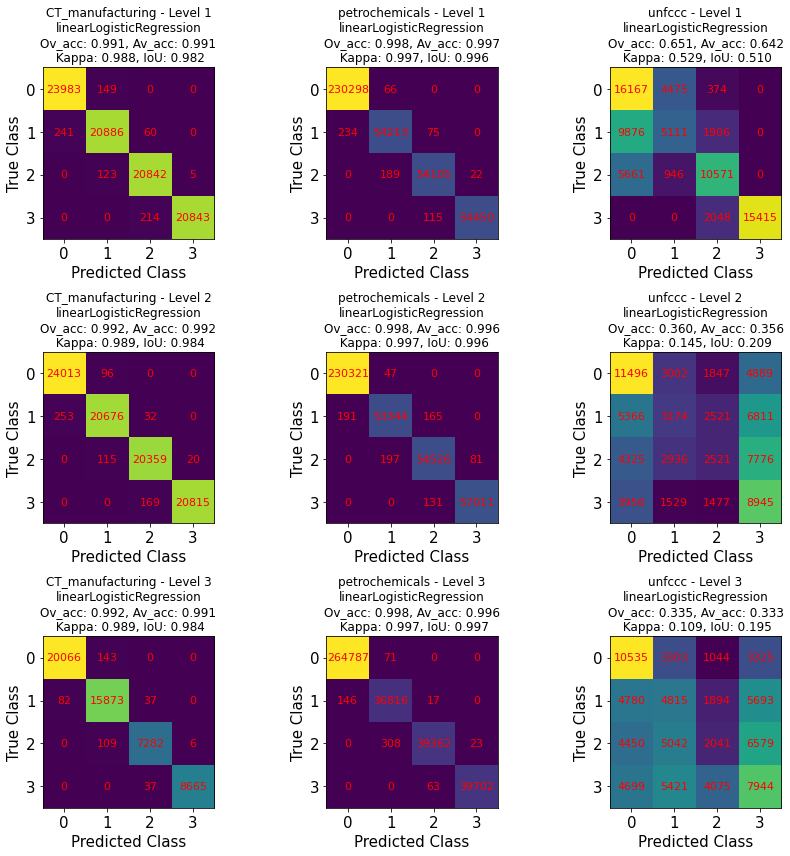

In [68]:
# Reload model scores

fig, ax = plt.subplots(int(np.ceil(len(clf_file_df_used)/3)), 3, figsize = [12, int(np.ceil(len(clf_file_df_used)/3)*4)], facecolor='white')

j=0
for i, model in enumerate(clf_file_df_used.iloc):
    scores = np.load(model_folder+model['Filepath'], allow_pickle=True).item()
    ax_curr = ax[int(np.floor(i/3)), j] if len(clf_file_df_used) > 3 else ax[int(np.floor(i/3))]

    ax_curr.set_title(model['Dataset']+' - Level '+ model['Classifier'].replace('__','_').split('_')[2][1]+
                      '\n'+model['Classifier'].split('_')[1]+
                      '\nOv_acc: {0:.3f}, Av_acc: {1:.3f}\n Kappa: {2:.3f}, IoU: {3:.3f}'.format(scores['overall_acc'], scores['average_acc'], scores['kappa'], scores['IoU']))
    plot_confusion(scores['confusion'], ax_curr)
    j = 0 if j==2 else j+1

fig.tight_layout()

## Check-out predictions

In [1]:
# Check out predictions

load_file = model_folder+'clf_randomForestClassifier_n50_230127.joblib'
model = joblib.load(load_file)

NameError: name 'model_folder' is not defined

In [93]:
X_train, X_test, y_train_values, y_train_cats, y_test_values, y_test_cats = [pd.read_csv(model_folder+file+'.csv', index_col=0) for file in ['X_train', 'X_test', 'y_train_values', 'y_train_cats', 'y_test_values', 'y_test_cats']]

In [94]:
X_train_pp = np.load(model_folder+'X_train.npy')
X_test_pp = np.load(model_folder+'X_test.npy')

In [79]:
y_pred = model.predict(X_train_pp)

In [84]:
metrics(y_pred, y_train_cats)

{'confusion': array([[382892,     87,    194,    466],
        [    74, 209996,    650,    302],
        [   194,    545, 212999,    852],
        [   440,    289,    792, 113897]], dtype=int64),
 'overall_acc': 0.9947170284718099,
 'average_acc': 0.9931496197459517,
 'kappa': 0.9925208838369026,
 'IoU': 0.9895195292343649}

In [98]:
merged = pd.merge(X_test, X_test.drop_duplicates(subset=list(X_train.columns[:6])), on=list(X_train.columns[:6]), how='left', suffixes=('', '_y'))

,PRODUCT,COUNTRY/TERRITORY,COMPANY,ROUTE,TECHNOLOGY,LICENSOR
0,EVA COPOLYMERS,SOUTH KOREA,HANWHA SOLUTIONS/CHEMICAL,VIRGIN RESIN,HP TUBULAR,DOW
1,PHTHALIC ANHYDRIDE,SOUTH KOREA,LG CHEM,O - XYLENE,OXIDATION,ATOCHEM
2,METHYL METHACRYLATES,BELARUS,POLYMIR,ACETONE CYANOHYDRIN,SYNTHESIS,n.a.
3,ADIPIC ACID,GERMANY,BASF,CYCLOHEXANE,OXIDATION,n.a.
4,LIGHT DISTILLATES DESULF,ITALY,RAFFINERIA DI GELA,HYDRODESULF-NAPHTHA,UNIVERSAL OIL PRODUCTS CO,n.a.
...,...,...,...,...,...,...
881457,ACRYLONITRILE,SPAIN,PAULAR,PROPYLENE,AMMOXIDATION,MONTEDISON
882298,PROPYLENE GLYCOLS,CANADA,DOW CHEMICAL,PROPYLENE OXIDE,n.a.,n.a.
888971,ETHYLENE,GERMANY,ERDOELCHEMIE,STEAM-CRACKING,STEAM CRACKING,STONE & WEBSTER
904034,POLYESTER FIBRES,UNITED STATES,DOW BADISCHE,PES POLYMER,n.a.,n.a.


In [80]:
import sklearn.metrics as skm

def metrics(y_true, y_pred, model_type='clf'):
    if model_type == 'clf':
        metric_dict = {'confusion': skm.confusion_matrix(y_true, y_pred),
                       'overall_acc': skm.accuracy_score(y_true, y_pred),
                       'average_acc': skm.balanced_accuracy_score(y_true, y_pred),
                       'kappa': skm.cohen_kappa_score(y_true, y_pred),
                       'IoU': skm.jaccard_score(y_true, y_pred, average='weighted')}
    elif model_type == 'reg':
        metric_dict = {'r2': skm.r2_score(y_true, y_pred),
                       'mae': skm.mean_absolute_error(y_true, y_pred),
                       'mse': skm.mean_squared_error(y_true, y_pred)}

    else: raise 'Incorrect model type'

    return metric_dict

In [82]:
y_train_cats

,Category
